# GRIPA 

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import isnan
from collections import defaultdict
import numpy as np
from sklearn.linear_model import LinearRegression
reader = pd.read_csv(r"..\podatki\US_gripa.csv")
virus_array = reader.get_values()    #create array of data
reader.head()

,geoid,Region,State,age,season,MMWR Year/Week,Deaths from influenza,Deaths from pneumonia,Deaths from pneumonia and influenza,All Deaths,Pecent of deaths due to pneumonia or influenza,pecent complete
0,State,NaN,New Hampshire,All,2017-18,201805,NaN,NaN,28.0,286.0,9.790210,143.277643
1,State,NaN,New York City,All,2015-16,201629,NaN,NaN,64.0,972.0,6.584362,97.618498
2,State,NaN,Missouri,All,2009-10,201020,NaN,NaN,84.0,984.0,8.536585,93.231242
3,Region,3.0,NaN,All,2010-11,201134,0.0,280.0,280.0,4662.0,6.006006,92.565116
4,State,NaN,Kansas,All,2017-18,201820,NaN,NaN,19.0,496.0,3.830645,105.194581


In [3]:
#PRIPRAVA ZA USA
#Geografsko_podrocje:
Geop = reader["geoid"]
Regija = reader["Region"]
State = reader["State"]
season = reader["season"]
smr_g = reader["Deaths from influenza"]
smr_pl = reader["Deaths from pneumonia"]
smr_gp = reader["Pecent of deaths due to pneumonia or influenza"]
smr_t = reader["All Deaths"]

In [4]:
#Tukajle poizksamo na kup spraviti smrti zaradi gripe

In [5]:
dfg = defaultdict(list)
dfp = defaultdict(list)
leta = set()
for y,sg,sp in zip(season,smr_g,smr_pl):
    if not isnan(sg) and not isnan(sp):
        dfg[y].append(float(sg))
        dfp[y].append(float(sp))
        leta.add(y)
leta = list(leta)

In [6]:
#Sortirajmo po letih  

In [7]:
leta.sort()
#trois seznames
dg = []
dp = []
for x in leta:
    dg.append(sum(dfg[x]))
    dp.append(sum(dfp[x]))

#Grafi po letih

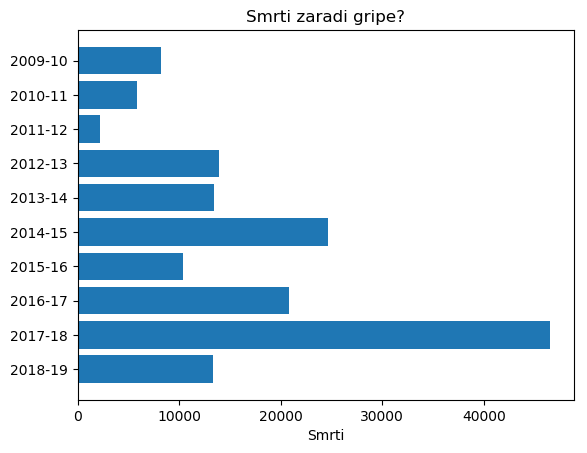

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility

y_pos = np.arange(len(leta))

plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, dg, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(leta)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Smrti')
ax.set_title('Smrti zaradi gripe?')

plt.show()

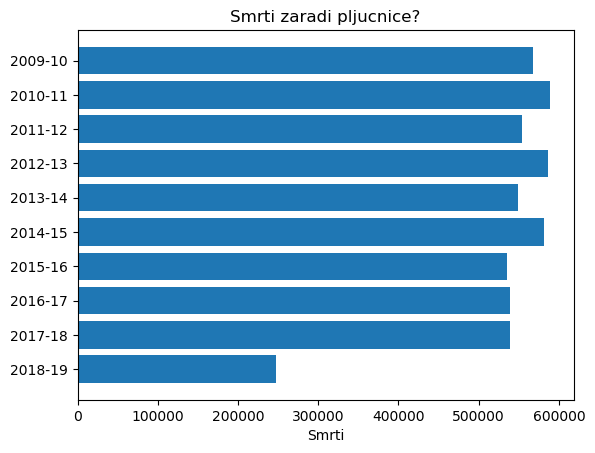

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility

y_pos = np.arange(len(leta))

plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, dp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(leta)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Smrti')
ax.set_title('Smrti zaradi pljucnice?')

plt.show()

OPAZANJE: Podatek za obdobje 2018_19 bi utegnil biti ne- veljaven saj vsepovsod velja, da imajo vzorci približno enako število primerov pri 2018-19 jih je le polovico(MERITVE SO NASTALE PO OBMOCJIH!NI OCITNO ZA VSA OBMOCJA)!

#Ali obstaja odvisnost med smrtmi taradi gripe in smrtmi zaradi plucnjice?(ITAK=D). Izpustili smo zadnje leto pri obeh datasetih, saj kaze na napacno metritev, kakorkoli tole bo treba gledat drugace se mi zdi treba bo kr use meritve posortirat po letih da dobimo vec podatkov, bomo imeli točnejšo regresijo.Tut mal mi ni jasno kako je mogoce da mamo negativen korelacijski koeficient.

In [10]:
from scipy.stats import pearsonr
pearsonr(dg[:-1], dp[:-1])
koef = pearsonr(dg[:-1], dp[:-1])[0]

In [11]:
#Ocitno majhen bo treba pogledati, zakaj

# Skupno st po smrti 


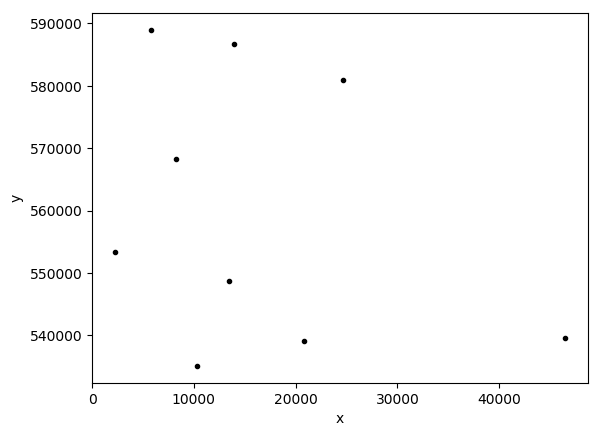

In [12]:
#Raztrosenst podatkov
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

plt.figure()
plt.plot(dg[:-1], dp[:-1], "k.")
plt.xlabel("x")
plt.ylabel("y")
model = LinearRegression()
plt.show()

#Smrti po tednih in districtih

In [26]:
#po okrajih
"""
Geop = reader["geoid"]
Regija = reader["Region"]
State = reader["State"]
season = reader["season"]
smr_g = reader["Deaths from influenza"]
smr_pl = reader["Deaths from pneumonia"]
smr_gp = reader["Pecent of deaths due to pneumonia or influenza"]
smr_t = reader["All Deaths"]
"""
import matplotlib.pyplot as plt
total = defaultdict(int)
pneum = defaultdict(int)
stejt = []
for kraj,grip,vsi in zip(State,smr_gp,smr_t):
    if not isnan(grip) and not isnan(vsi):
        stejt.append(kraj)
        total[kraj] += int(grip)
        pneum[kraj] += int(vsi)
stejt  = list(set(stejt))
grp = []
vs = []
for x in stejt:
    grp.append(total[x])
    vs.append(pneum[x])


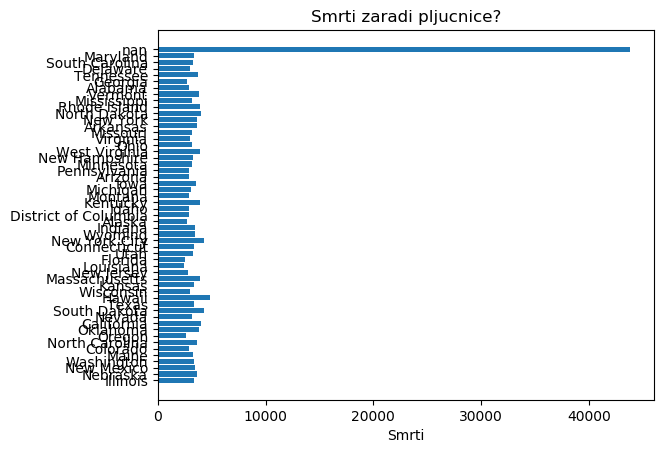

In [44]:
y_pos = np.arange(len(stejt))

plt.rcdefaults()
fig, ax = plt.subplots()
matplotlib.rc('xtick', labelsize=5) 
ax.figsize=(15, 10)
ax.barh(y_pos, grp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(stejt)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Smrti')
ax.set_title('Smrti zaradi pljucnice?')
  # labels read top-to-bottom

plt.show()
